### TYK2 Full-Length DMS Variant Interpretation



1. [Allele Frequencies](#part1)
2. [ClinVar](#part2)
3. [EVE and ESM1b](#part3)
4. [SIFT and Polyphen2](#part4)
5. [AlphaMissense](#part5)

In [2]:
library(ggpubr)
library(ggsci)
library(ggbeeswarm)
library(tidyverse)

In [3]:
aalet <- read_tsv("../data/annotations/aa-letters.tsv", col_names = c("full", "thr", "aa"))
wtseq <- read_tsv("../data/tyk2/tyk2-wt-aa.tsv")

sumstats <- read_tsv("../sumstats/TYK2/run3/tyk2-assay3.tsv") %>%
     mutate(condition = factor(condition,
                              levels = c("IFNbeta100 - None0",
                                         "IFNalpha1 - None0",
                                         "IFNalpha10 - None0",
                                         "IFNalpha100 - None0",
                                         "IFNalphaWithDrug100 - None0",
                                         "None0 - IFNbeta100",
                                         "IFNalpha1 - IFNbeta100",
                                         "IFNalpha10 - IFNbeta100",
                                         "IFNalpha100 - IFNbeta100",
                                         "IFNalphaWithDrug100 - IFNbeta100"))) %>%
    inner_join(wtseq, by = c("pos")) %>%
    inner_join(aalet, by = c("aa")) %>%
    inner_join(aalet, by = c("wt_aa" = "aa")) %>%
    mutate(mut = paste0(thr.y, pos, thr.x))

Rows: 22 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): full, thr, aa

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 237230 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): clone, chunk, aa, version, condition
dbl (7): pos, estimate, std.error, dispersion, statistic, p.value, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Allele Frequencies <a name="part1"></a>

Each variant has a population-level allele frequency, which we can plot for each global population for which we have data from Gnomad. In the plots below, red points are significant in the DMS data at an adjusted p-value < 0.01:

In [5]:
varinfo <- read_tsv("../data/annotations/TYK2-vep.tsv.gz", comment = "##") %>%
    filter(Feature == "ENST00000525621", grepl("missense", Consequence)) %>%
    select(Protein_position, Amino_acids, matches("gnomAD")) %>%
    pivot_longer(names_to = "group", values_to = "allele_frequency", matches("gnomAD")) %>%
    filter(allele_frequency != "-") %>%
    mutate(allele_frequency = as.numeric(allele_frequency)) %>%
    group_by(Protein_position, Amino_acids, group) %>%
    summarize(allele_frequency = sum(allele_frequency)) %>%
    separate(Amino_acids, c("wt_aa", "mut_aa"), "/") %>%
    rename("pos" = "Protein_position") %>%
    mutate(pos = as.numeric(pos))

sumstats_vep <- sumstats %>%
    inner_join(varinfo, by = c("pos" = "pos",
                               "aa" = "mut_aa"))

Rows: 24326 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (28): #Uploaded_variation, Location, Allele, Gene, Feature, Feature_type...
dbl  (1): STRAND

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'Protein_position', 'Amino_acids'. You can
override using the `.groups` argument.
Warning message in inner_join(., varinfo, by = c(pos = "pos", aa = "mut_aa")):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 51 of `x` matches multiple rows in `y`.
ℹ Row 3268 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


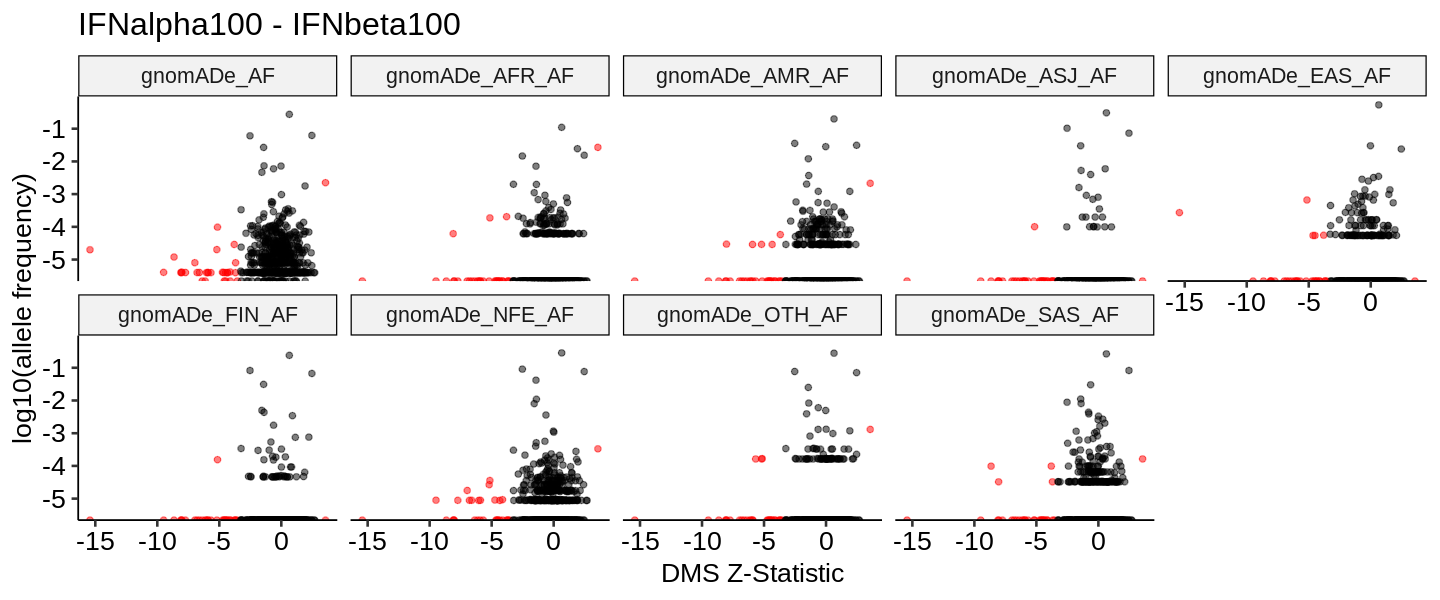

In [17]:
options(repr.plot.width = 12, repr.plot.height = 5)
sumstats_vep %>%
    filter(condition == "IFNalpha100 - None0") %>%
    ggplot() +
        geom_point(aes(x = statistic,
                       y = log10(allele_frequency),
                       color = if_else(p.adj < 0.01, "red", "black")),
                   alpha = 0.5) +
        theme_pubr(base_size = 16) +
        facet_wrap(~group, nrow = 2) +
        xlab("DMS Z-Statistic") + ylab("log10(allele frequency)") +
        scale_color_identity() +
        ggtitle("IFNalpha100 - IFNbeta100")

#### ClinVar <a name="part2"></a>

There are 316 missense variants in TYK2 noted in ClinVar, which we can compare to our data stratified by ClinVar classification from Benign to Pathogenic. Notably, P1104A is classified as Benign/Likely Benign, so there is not necessairly a strong expectation that our functional effects should associate strongly with a ClinVar class:

In [8]:
tyk2_clinvar <- read_tsv("../data/annotations/TYK2-clinvar-missense.tsv.gz") %>%
    select(Name, `Clinical significance (Last reviewed)`) %>%
    rename("class" = "Clinical significance (Last reviewed)") %>%
    separate(Name, c("id", "mut"), sep = " ") %>%
    mutate(mut = gsub("\\(|\\)|p.","",mut),
           class = gsub("\\(.*","",class)) %>%
    select(-id) %>%
    distinct()

New names:
* `` -> ...16

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 316 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): Name, Gene(s), Protein change, Condition(s), Clinical significance ...
dbl (6): GRCh37Chromosome, GRCh37Location, GRCh38Chromosome, GRCh38Location,...
lgl (1): ...16

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


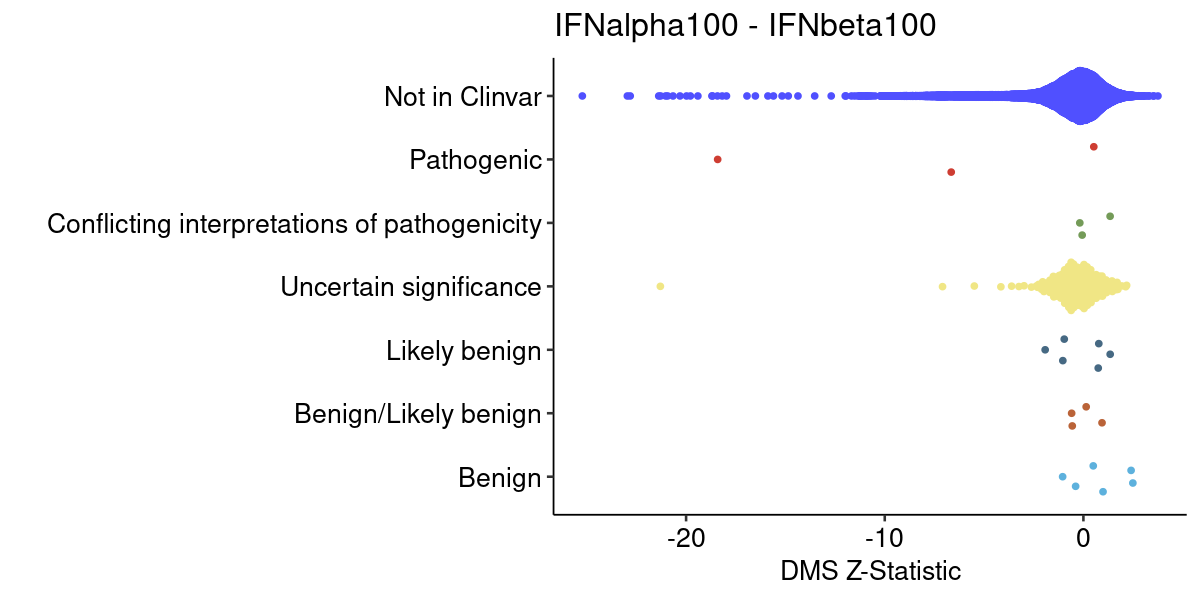

In [32]:
options(repr.plot.width = 10, repr.plot.height = 5)
sumstats %>%
    left_join(tyk2_clinvar, by = "mut") %>%
    mutate(class = if_else(is.na(class), "Not in Clinvar", class),
           class = factor(class, levels = c("Not in Clinvar",
                                            "Pathogenic",
                                            "Conflicting interpretations of pathogenicity",
                                            "Uncertain significance",
                                            "Likely benign",
                                            "Benign/Likely benign",
                                            "Benign"))) %>%
    filter(condition == "IFNalpha100 - IFNbeta100") %>%
    ggplot(aes(y = statistic, x = fct_rev(class), color = class)) +
        geom_quasirandom() +
        theme_pubr(base_size = 16) +
        ylab("DMS Z-Statistic") + xlab("") +
        coord_flip() +
        theme(legend.pos = "none") +
        scale_color_igv() +
        ggtitle("IFNalpha100 - IFNbeta100")

The vast majority of variants are either not in ClinVar, or are of uncertain significance. So, if we extract all variants NOT in either of those two categories, we can show them together in a table with the DMS adjusted p-value:

In [40]:
sumstats %>%
    left_join(tyk2_clinvar, by = "mut") %>%
    mutate(class = if_else(is.na(class), "Not in Clinvar", class),
           class = factor(class, levels = c("Not in Clinvar",
                                            "Pathogenic",
                                            "Conflicting interpretations of pathogenicity",
                                            "Uncertain significance",
                                            "Likely benign",
                                            "Benign/Likely benign",
                                            "Benign"))) %>%
    filter(!class %in% c("Not in Clinvar", "Uncertain significance"), condition == "IFNalpha100 - IFNbeta100") %>%
    select(mut, class, p.adj) %>%
    arrange(class) %>%
    rename("mutation" = "mut",
           "ClinVar category" = "class",
           "DMS adjusted p-value" = "p.adj") %>%
    knitr::kable("markdown")



|mutation   |ClinVar category                             | DMS adjusted p-value|
|:----------|:--------------------------------------------|--------------------:|
|Leu757Val  |Pathogenic                                   |            0.9335208|
|Gly799Arg  |Pathogenic                                   |            0.0000000|
|Leu1014Pro |Pathogenic                                   |            0.0000000|
|Arg701Thr  |Conflicting interpretations of pathogenicity |            0.6937203|
|Arg118Gln  |Conflicting interpretations of pathogenicity |            0.9815307|
|Gly512Arg  |Conflicting interpretations of pathogenicity |            0.9939568|
|Gly39Ser   |Likely benign                                |            0.8078417|
|Gly634Glu  |Likely benign                                |            0.8872849|
|Gly761Val  |Likely benign                                |            0.8803602|
|Pro871Ser  |Likely benign                                |            0.6923552|
|His993Tyr  |L

#### EVE and ESM1b <a name="part3"></a>

EVE (both scores from the Marks lab) and ESB1b have extremely similar patterns:

In [59]:
eve_scores_b05 <- read_csv("../data/annotations/TYK2_HUMAN_b05_20000_samples.csv") %>%
    mutate(mutations = gsub("^.","",mutations)) %>%
    select(-protein_name) %>%
    filter(mutations != "t") %>%
    separate(mutations, c("pos", "aa"), sep = -1) %>%
    rename("EVE Score 1" = "evol_indices") %>%
    mutate(pos = as.numeric(pos))

eve_scores_b03 <- read_csv("../data/annotations/TYK2_HUMAN_b03_20000_samples.csv") %>%
    mutate(mutations = gsub("^.","",mutations)) %>%
    select(-protein_name) %>%
    filter(mutations != "t") %>%
    separate(mutations, c("pos", "aa"), sep = -1) %>%
    rename("EVE Score 2" = "evol_indices") %>%
    mutate(pos = as.numeric(pos))

eve_scores <- inner_join(eve_scores_b05, eve_scores_b03, by = c("pos", "aa"))

Rows: 19153 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): protein_name, mutations
dbl (1): evol_indices

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 19913 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): protein_name, mutations
dbl (1): evol_indices

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


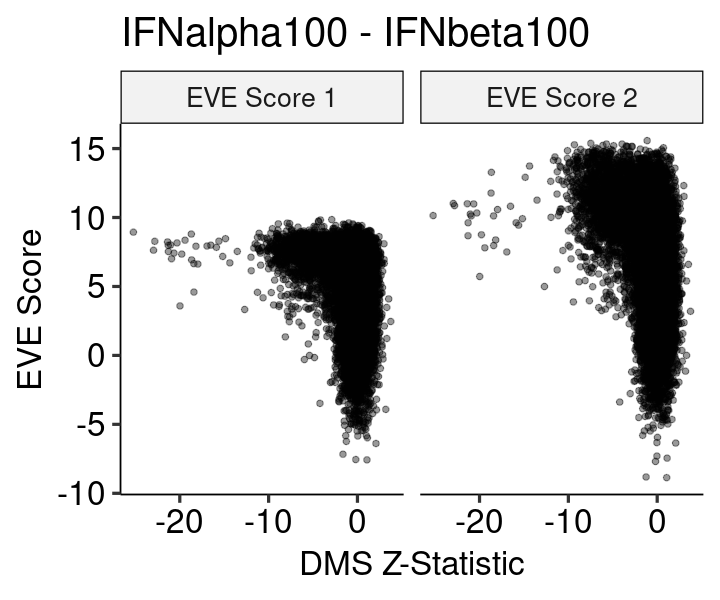

In [67]:
options(repr.plot.witdh = 10, repr.plot.height = 5)
sumstats %>%
    filter(condition == "IFNalpha100 - IFNbeta100") %>%
    inner_join(eve_scores, by = c("pos", "aa")) %>%
    pivot_longer(names_to = "stat", values_to = "eve_score", `EVE Score 1`:`EVE Score 2`) %>%
    ggplot() +
        geom_point(aes(x = statistic, y = eve_score), alpha = 0.4) +
        theme_pubr(base_size = 20) +
        facet_wrap(~stat, nrow = 1) +
        xlab("DMS Z-Statistic") + ylab("EVE Score") +
        ggtitle("IFNalpha100 - IFNbeta100")

In [62]:
esm1b <- read_csv("../data/annotations/TYK2-ESM1b.csv") %>%
    mutate(wt_aa = str_sub(variant, 1, 1),
           mut_aa = str_sub(variant, -1))

Rows: 23740 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): variant
dbl (2): score, pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


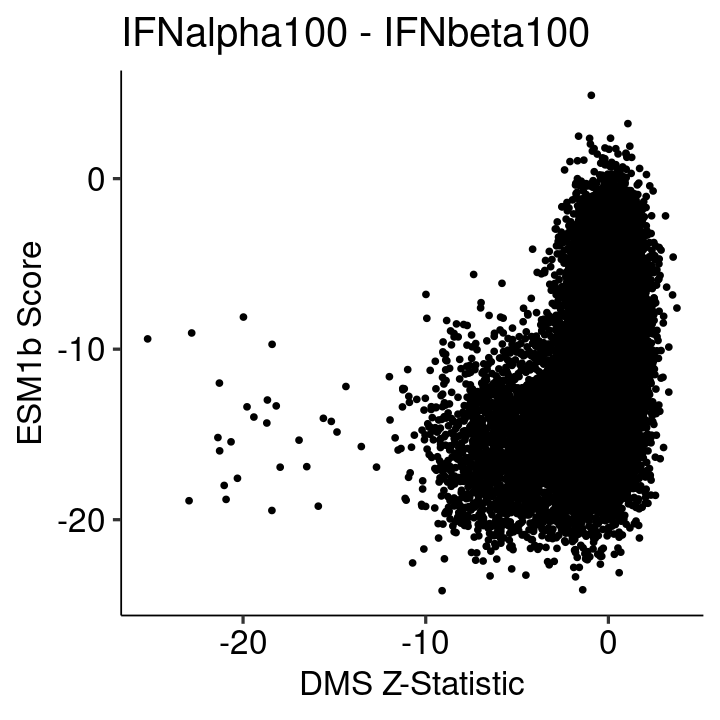

In [68]:
options(repr.plot.width = 6, repr.plot.height = 6)
sumstats %>%
    filter(condition == "IFNalpha100 - IFNbeta100") %>%
    inner_join(esm1b, by = c("pos" = "pos",
                             "aa" = "mut_aa")) %>%
    ggplot() +
        geom_point(aes(x = statistic, y = score))  +
        theme_pubr(base_size = 20) +
        xlab("DMS Z-Statistic") + ylab("ESM1b Score") +
        ggtitle("IFNalpha100 - IFNbeta100")

#### SIFT and PolyPhen2 <a name="part4"></a>

The older predictors also have L-shaped patterns, though with visibly lower resolution to distinguish between similar variants:

In [98]:
tyk2_sift <- read_delim("../data/annotations/TYK2-sift.tsv.gz", delim = " ") %>%
    pivot_longer(names_to = "aa", values_to = "sift", A:Y) %>%
    mutate(mut = paste0(wt, aa)) %>%
    select(mut, sift)

tyk2_polyp <- read_tsv("../data/annotations/TYK2-polyphen2.tsv.gz") %>%
    select(o_pos, o_aa2, pph2_prob) %>%
    rename("PolyPhen2" = "pph2_prob")

sumstats_siftphen <- sumstats %>%
    mutate(mut = paste0(pos, wt_aa, aa)) %>%
    left_join(tyk2_sift, by = "mut") %>%
    left_join(tyk2_polyp, by = c("pos" = "o_pos",
                                 "aa" = "o_aa2"))

Rows: 1187 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: " "
chr  (1): wt
dbl (21): cons, A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 22558 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (8): #o_acc, o_aa1, o_aa2, rsid, acc, aa1, aa2, prediction
dbl (5): o_pos, pos, pph2_prob, pph2_FPR, pph2_TPR

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“One or more parsing issues, see `problems()` for details”


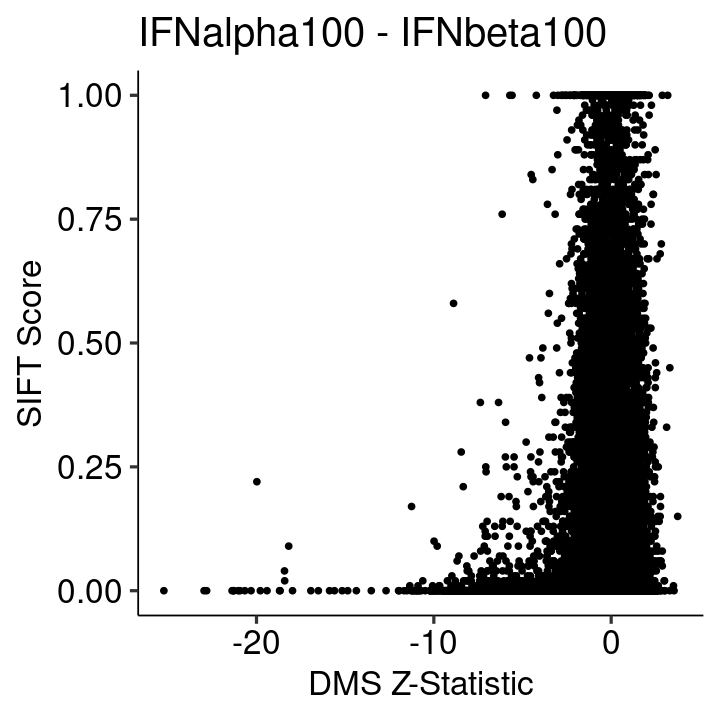

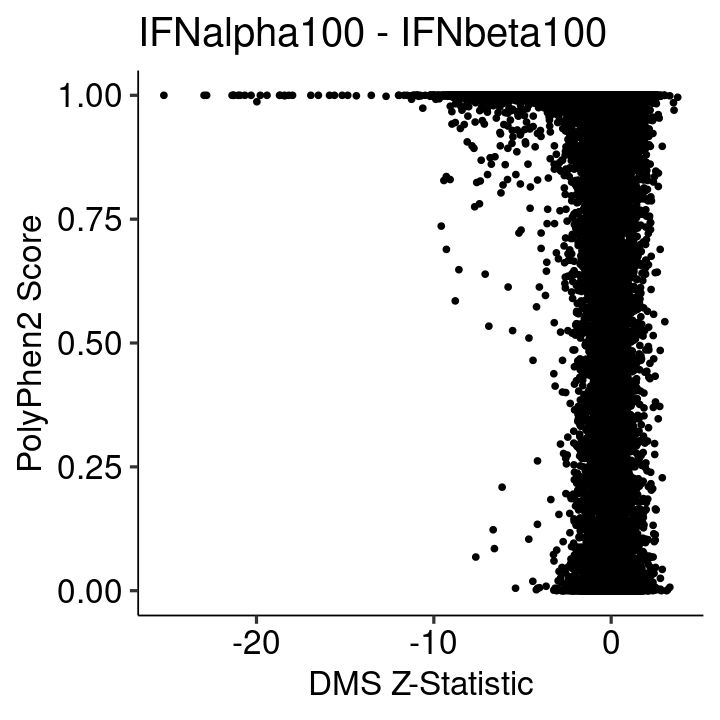

In [102]:
sumstats_siftphen %>%
    filter(condition == "IFNalpha100 - IFNbeta100") %>%
    ggplot() +
        geom_point(aes(x = statistic, y = sift))  +
        theme_pubr(base_size = 20) +
        xlab("DMS Z-Statistic") + ylab("SIFT Score") +
        ggtitle("IFNalpha100 - IFNbeta100")

sumstats_siftphen %>%
    filter(condition == "IFNalpha100 - IFNbeta100") %>%
    ggplot() +
        geom_point(aes(x = statistic, y = PolyPhen2))  +
        theme_pubr(base_size = 20) +
        xlab("DMS Z-Statistic") + ylab("PolyPhen2 Score") +
        ggtitle("IFNalpha100 - IFNbeta100")

#### AlphaMissense <a name="part5"></a>

Comparing AlphaMissense variant effect predictions with TYK2 VAMP-seq for chunk 10.

In [30]:
sumstats_vamp <- read_tsv("../sumstats/TYK2-VAMP/midpoint/vamp-10-midpoint-sumstats.tsv") %>%
    inner_join(wtseq, by = c("pos")) 

Rows: 1400 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): mut_aa
dbl (8): score_mean, score_sd, pos, estimate, std.error, statistic, p.value,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [19]:
alphamissense <- read_tsv("~/tyk2-alphamissense.tsv",
                          col_names = c("uniprot_id" ,"mut_id", "score", "AlphaMissense Class"))

Rows: 18336 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): uniprot_id, mut_id, AlphaMissense Class
dbl (1): score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [57]:
p1 <- sumstats_vamp %>%
    mutate(mut_id = str_c(wt_aa, pos, mut_aa)) %>%
    left_join(alphamissense) %>%
    ggplot() +
        geom_point(aes(y = estimate, x = score, color = `AlphaMissense Class`)) +
        theme_pubr() +
        ylab("FlowDMS Estimated Midpoint Shift, Chunk 10") +
        xlab("Alpha-Missense Score") +
        scale_color_manual(values = c("pathogenic" = "blue", "ambiguous" = "red", "benign" = "darkgreen"))

p2 <- sumstats_vamp %>%
    mutate(mut_id = str_c(wt_aa, pos, mut_aa)) %>%
    left_join(alphamissense) %>% 
    mutate(`AlphaMissense Class` = factor(`AlphaMissense Class`, levels = c("benign", "ambiguous", "pathogenic"))) %>%
    filter(!is.na(`AlphaMissense Class`)) %>%
    ggplot() +
        geom_quasirandom(aes(y = estimate, x = `AlphaMissense Class`, color = `AlphaMissense Class`)) +
        geom_boxplot(aes(y = estimate, x = `AlphaMissense Class`, color = `AlphaMissense Class`), width = 0.2) +
        theme_pubr() +
        ylab("FlowDMS Estimated Midpoint Shift, Chunk 10") +
        xlab("Alpha-Missense Predicted Class") +
        scale_color_manual(values = c("pathogenic" = "blue", "ambiguous" = "red", "benign" = "darkgreen"))

Joining with `by = join_by(mut_id)`
Joining with `by = join_by(mut_id)`


Warning message:
“Removed 70 rows containing missing values (`geom_point()`).”


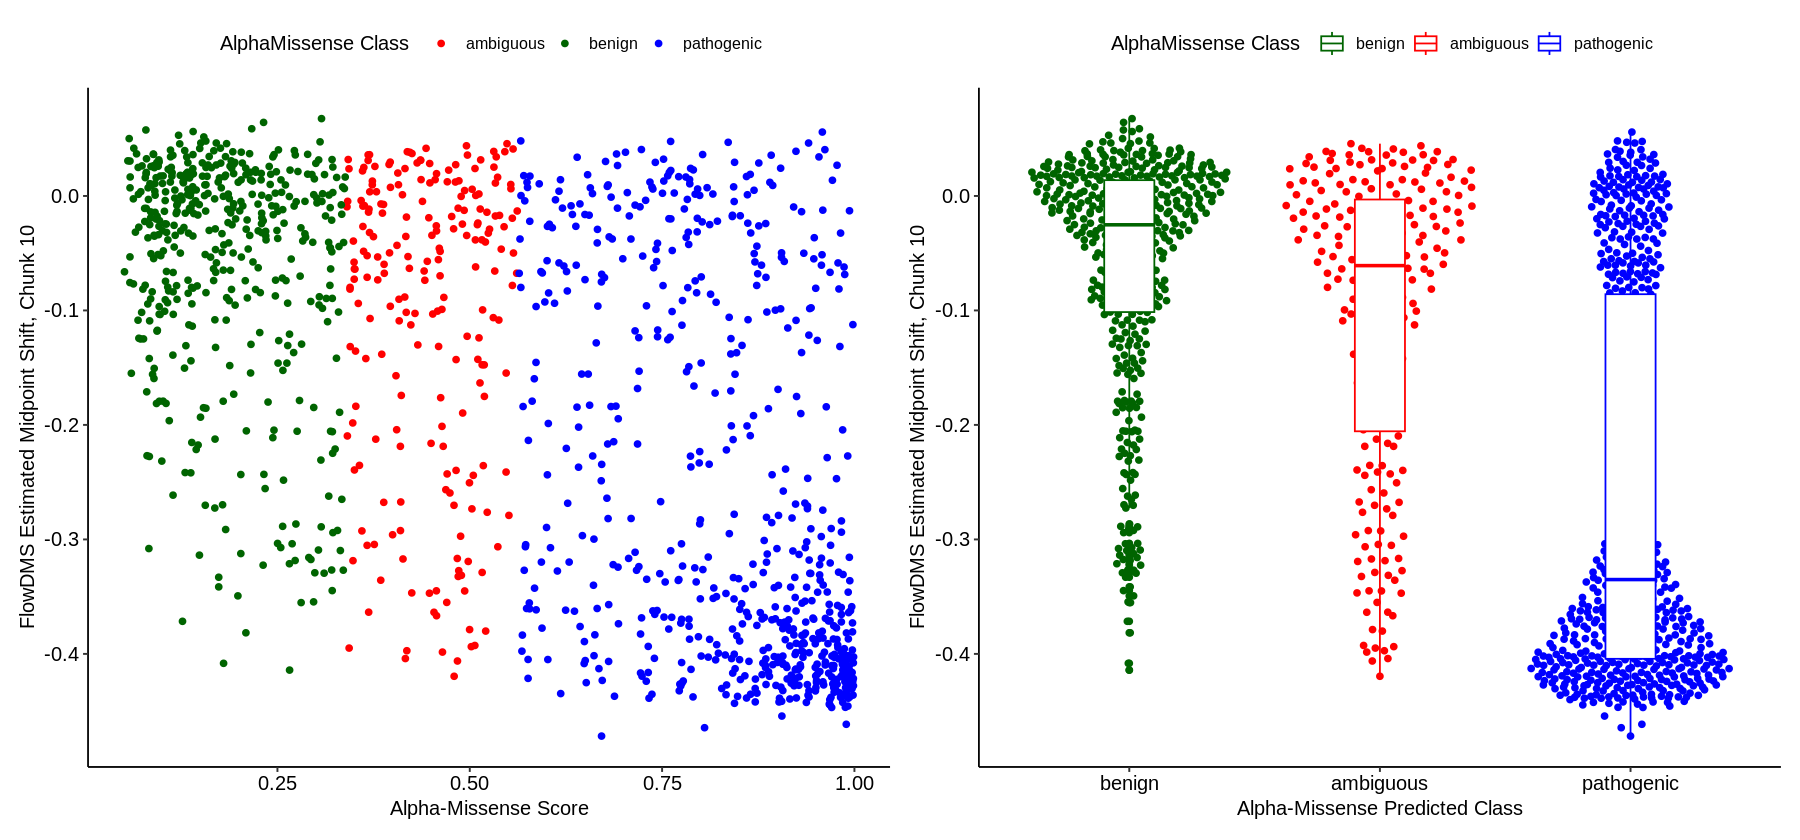

In [60]:
options(repr.plot.width = 15, repr.plot.height = 7)
p1 + p2